## Import and preprocess datasets

In [1]:
import numpy as np
from netCDF4 import Dataset
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from sklearn.ensemble.forest import RandomForestRegressor, RandomForestClassifier
import os
from sklearn import preprocessing, metrics
from importlib import reload
import sknn_jgd.mlp
from sklearn import tree  #for graphing random forest tree
import pickle
%matplotlib inline
pylab.rcParams['figure.figsize'] = (10, 6)
inline_rc = dict(mpl.rcParams)
import src.nnload as nnload
import src.nntrain as nntrain
import src.nnplot as nnplot
# Set script parameters
minlev = 0.2
rainonly = False
write_nn_to_netcdf = False
fig_dir = './figs/'
data_dir = './data/'

/Users/jgdwyer/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/jgdwyer/anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [7]:
r_str= 'X-StandardScaler-qTindi_Y-SimpleY-qTindi_Ntrnex400000_r_50R_50R_mom0.9reg1e-07_Niter10000_v3'
training_file='./data/conv_testing_v3.pkl'
r_mlp_eval, _, errors, x_ppi, y_ppi, x_pp, y_pp, lat, lev, dlev = \
        pickle.load(open('./data/regressors/' + r_str + '.pkl', 'rb'))
# Load the data from the training/testing/validation file
x_scl, ypred_scl, ytrue_scl, x_unscl, ypred_unscl, ytrue_unscl = \
    nnload.get_x_y_pred_true(r_str, training_file, minlev=min(lev),
                             noshallow=False, rainonly=False)

There is some amount of rain 58.6% of the time
There is a rate of >3 mm/day 28.6% of the time
There is convection 65.1% of the time


In [31]:
reload(nnplot)
figpath = './figs/' + r_str + '/'
nnplot.plot_sample_profiles(1, x_unscl, ytrue_unscl, ypred_unscl, lev, figpath,samp=32337)

/Users/jgdwyer/anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [15]:
from imp import reload
reload(nnplot)
nnplot.meta_compare_error_rate_v2()

/Users/jgdwyer/anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


AttributeError: module 'src.nnplot' has no attribute 'meta_compare_error_rate_v2'

/Users/jgdwyer/anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


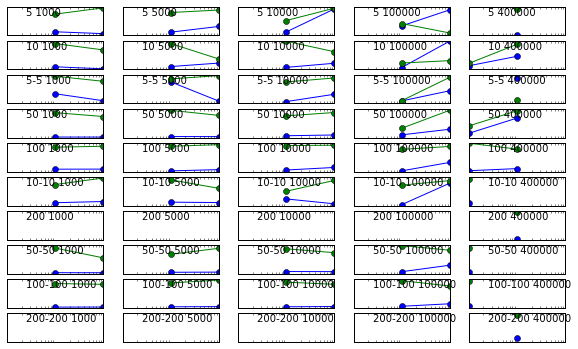

In [215]:
reload(nnplot)
nnplot.meta_plot_regs()

/Users/jgdwyer/anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


GCM Precip is: 1.43
MLP Precip is: 0.14
DBM Precip is: 0.00


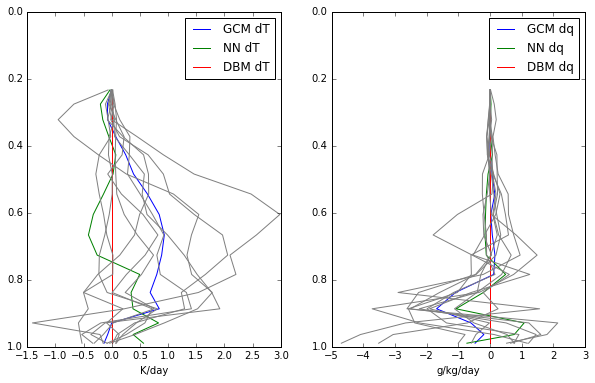

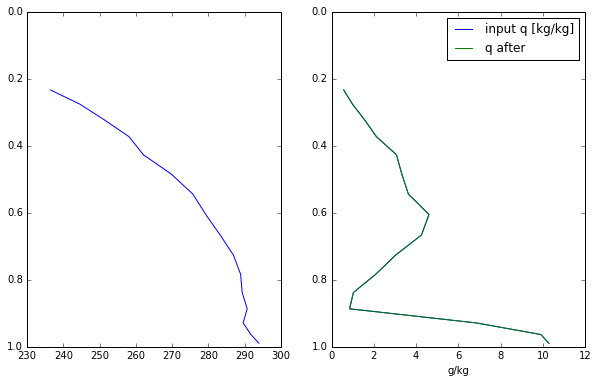

In [11]:
reload(nnplot)
nnplot.plot_neural_fortran('/Users/jgdwyer/day1100h00.1xday.nc.0001',
                           'X-StandardScaler-qTindi_Y-SimpleY-qTindi_Ntrnex125000_r_50R_mom0.9reg1e-06_Niter3000_v3',
                           latind=None, timeind=99,
                        ensemble=True)